# SherLock

## Load Libraries

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import pickle

## Load Data

This will cycle through all the data found in the Kaggle subset data, 'archive'.

### Functions Used

In [2]:
# Functions
def editTextFile(f):
    # Read in the file
    with open(f, 'r') as file:
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace('[msec],size', '[msec];size')

    # Write the file out again
    with open('editTextFile.txt', 'w') as file:
        file.write(filedata)
        
def magVector(df,col1,col2,col3):
    # Calculate magnitude of vector - SQRT(X^2 + Y^2 + Z^2)
    return ((df[col1].pow(2) + df[col2].pow(2) + df[col3].pow(2)).pow(1/2))        

### Loading

In [3]:
# Non-standard columns present, need function to fix
#filename = './archive/AllBroadcasts.csv'
#AllBroadcasts = pd.read_csv(filename)
#AllBroadcasts['UUID'] = AllBroadcasts['UUID'].apply(pd.to_datetime, unit='ms')

# Drop bad rows for now...
#alphabet_string = string.ascii_lowercase
#alphabet_list = list(alphabet_string)

#AllBroadcasts[AllBroadcasts['timestamp'].str().isin(alphabet_list)]

#indexID = AllBroadcasts[(AllBroadcasts['timestamp'] >= 21)].index
#AllBroadcasts.drop(indexID, inplace = True)


#AllBroadcasts.head(3)

In [41]:
filename = './archive/AppPackages.csv'
AppPackages = pd.read_csv(filename)    # Ending columns need to be appended into sherlock_version - make function!

AppPackages[['UUID','InstallTime']] = AppPackages[['UUID', 'InstallTime']].apply(pd.to_datetime, unit='ms')
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 13'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 14'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 15'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 16'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 17'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 18'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 19'],sep=",")
#AppPackages['sherlock_version'] = AppPackages['sherlock_version'].str.cat(AppPackages['Unnamed: 20'],sep=",")
#AppPackages.drop([])
#AppPackages = AppPackages.set_index('UUID')
print(AppPackages['UserId'].unique())
AppPackages = AppPackages.drop(columns=['UserId'])
print(AppPackages.shape)
AppPackages.head(3)

['97bb95f55a']
(298, 20)


,UUID,Action,AppPackage,AppUID,App_Name,InstallSrc,InstallTime,PackageHASH,Permissions,versionName,versionCode,sherlock_version,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,2016-04-27 23:33:20,Changed,com.google.android.gms,10012.0,Google Play services,com.android.vending,2014-12-18 10:53:20,c5762e46cb3b6c1585a8cdf95e2516ee473a5a7b,[android.permission.GET_ACCOUNTS,android.permission.INTERNET,android.permission.USE_CREDENTIALS,android.permission.SYSTEM_ALERT_WINDOW,android.permission.RECEIVE_BOOT_COMPLETED,com.google.android.providers.gsf.permission.RE...,android.permission.O,8.7.03 (2645110-238),8703238,2.2,NaN,NaN
1,2016-04-27 23:33:20,Changed,com.google.android.gms,10012.0,Google Play services,com.android.vending,2014-12-18 10:53:20,c5762e46cb3b6c1585a8cdf95e2516ee473a5a7b,[android.permission.GET_ACCOUNTS,android.permission.INTERNET,android.permission.USE_CREDENTIALS,android.permission.SYSTEM_ALERT_WINDOW,android.permission.RECEIVE_BOOT_COMPLETED,com.google.android.providers.gsf.permission.RE...,android.permission.O,8.7.03 (2645110-238),8703238,2.2,NaN,NaN
2,2016-04-27 23:33:20,Added,com.google.android.music,10128.0,Google Play Music,com.android.vending,2014-12-18 10:53:20,655b0ff9207bd4123a8eb3d7c8c383c94f32a0dc,[android.permission.WRITE_SETTINGS,android.permission.SYSTEM_ALERT_WINDOW,android.permission.WAKE_LOCK,android.permission.INTERNET,android.permission.WRITE_EXTERNAL_STORAGE,android.permission.MANAGE_ACCOUNTS,android.permission.GET_ACCOUNTS,android.permissi,6.7.2713Z.2790541,2713,2.2,NaN


In [51]:
filename = './archive/Bluetooth.csv'
Bluetooth = pd.read_csv(filename, parse_dates=['Bluetooth_timestamp'])
Bluetooth = Bluetooth.rename(columns={"UserID": "UUID", "UUID": "UserID"})   # Header names swapped apparently
Bluetooth['UUID'] = Bluetooth['UUID'].apply(pd.to_datetime, unit='ms')
#Bluetooth = Bluetooth.set_index('UUID')
print(Bluetooth['UserID'].unique())
Bluetooth = Bluetooth.drop(columns=['UserID'])
print(Bluetooth.shape)
Bluetooth.head(3)

['97bb95f55a']
(4398, 10)


,UUID,Bluetooth_appearance,Bluetooth_class,Bluetooth_mAddress,Bluetooth_mRemoteBrsf,Bluetooth_mValueNREC,Bluetooth_mValueWBS,Bluetooth_name,Bluetooth_rssi,Bluetooth_timestamp
0,2016-04-27 21:38:25.533,0,5898764,0xE2591A4C3997E31D4BBA5C097862EAA3,NaN,NaN,NaN,0x13791B190947B0A48F1B9A73B1F9E2E0,-102,2016-04-28 00:38:25.529
1,2016-04-27 21:39:25.621,0,5898764,0xE2591A4C3997E31D4BBA5C097862EAA3,NaN,NaN,NaN,0x13791B190947B0A48F1B9A73B1F9E2E0,-101,2016-04-28 00:39:25.616
2,2016-04-27 21:40:25.711,0,5898764,0xE2591A4C3997E31D4BBA5C097862EAA3,NaN,NaN,NaN,0x13791B190947B0A48F1B9A73B1F9E2E0,-103,2016-04-28 00:40:25.688


In [48]:
filename = './archive/Calls.csv'
Calls = pd.read_csv(filename)
Calls[['UUID','Date']] = Calls[['UUID',
                                'Date']].apply(pd.to_datetime, unit='ms')
Calls['FromContacts'] = Calls['FromContacts'].astype(int)                      # Original True/False
#Calls = Calls.set_index('UUID')
print(Calls['UserId'].unique())
Calls = Calls.drop(columns=['UserId'])
print(Calls.shape)
Calls.head(3)

['97bb95f55a']
(1748, 6)


,UUID,Address,Date,Duration,FromContacts,Type
0,2016-04-28 11:42:11.668,c68ad8910c1a649507984b227f2c298140cf593c,2016-04-28 10:54:32.706,562,1,2
1,2016-04-28 11:42:11.668,9ef2cc0b1bd70f3610f022e9807568ae41d87547,2016-04-28 11:12:15.288,103,1,1
2,2016-04-28 11:47:18.056,c68ad8910c1a649507984b227f2c298140cf593c,2016-04-28 10:54:32.706,562,1,2


In [49]:
filename = './archive/Moriarty.csv'
editTextFile(filename)
Moriarty = pd.read_csv('editTextFile.txt')
Moriarty['UUID'] = (pd.to_datetime(Moriarty['UUID'], unit='ms'))
#Moriarty = Moriarty.set_index('UUID')
print(Moriarty['UserId'].unique())
Moriarty = Moriarty.drop(columns=['UserId'])
print(Moriarty.shape)
Moriarty.head(3)

['97bb95f55a']
(186, 7)


,UUID,Details,Action,ActionType,SessionType,Version,SessionID
0,2016-04-28 13:56:55.453,Added shortcut to the home screen(app);skype,Add Shortcut,malicious,malicious,5.0,0
1,2016-05-01 05:35:20.285,Login screen launched(login app);Skype,Shortcut Tapped,malicious,malicious,5.0,3
2,2016-05-01 05:35:20.288,App Entered onCreate(),App Mode Change,malicious,malicious,5.0,3


In [50]:
filename = './archive/ScreenOn.csv'
ScreenOn = pd.read_csv(filename, parse_dates=['Timestamp'])
ScreenOn['UUID'] = (pd.to_datetime(ScreenOn['UUID'], unit='ms'))
ScreenOn['ScreenOn'] = ScreenOn['ScreenOn'].astype(int)                    # Original True/False
#ScreenOn = ScreenOn.set_index('UUID')
print(ScreenOn['UserID'].unique())
ScreenOn = ScreenOn.drop(columns=['UserID'])
print(ScreenOn.shape)
ScreenOn.head(3)

['97bb95f55a']
(1929, 3)


,UUID,ScreenOn,Timestamp
0,2016-04-27 23:21:44.991,1,2016-04-28 02:21:44.991
1,2016-04-27 23:22:50.983,0,2016-04-28 02:22:50.982
2,2016-04-27 23:25:35.929,1,2016-04-28 02:25:35.929


In [53]:
filename = './archive/SMS.csv'
SMS = pd.read_csv(filename)
SMS[['UUID','Date']] = SMS[['UUID','Date']].apply(pd.to_datetime, unit='ms')
SMS[['ContainsURL', 'FromContacts']] = SMS[['ContainsURL', 
                                            'FromContacts']].astype(int)   # Original True/False
#SMS = SMS.set_index('UUID')
print(SMS['UserId'].unique())
SMS = SMS.drop(columns=['UserId'])
print(SMS.shape)
SMS.head(3)

['97bb95f55a']
(605, 6)


,UUID,Address,ContainsURL,Date,FromContacts,Type
0,2016-05-02 09:20:06.299,db61c51fb5a33d6e9e9cfb0bd06cfc6fc355aee9,0,2016-05-02 09:01:43.741,1,2
1,2016-05-02 19:37:00.128,06f0f34118867835b064b5c8b0c8a608f63c8833,0,2016-05-02 19:30:42.462,1,2
2,2016-05-02 20:37:00.765,06f0f34118867835b064b5c8b0c8a608f63c8833,0,2016-05-02 19:43:20.141,1,1


In [54]:
filename = './archive/T0.csv'
T0 = pd.read_csv(filename, parse_dates=['Telephoney_timestemp', 
                                        'SystemInfo_timestemp'])
T0['UUID'] = (pd.to_datetime(T0['UUID'], unit='ms'))
#T0 = T0.set_index('UUID')
print(T0['UserId'].unique())
T0 = T0.drop(columns=['UserId'])
print(T0.shape)
T0.head(3)

['97bb95f55a']
(42, 28)


,UUID,Version,Telephoney_deviceId,Telephoney_deviceSoftwareVersion,Telephoney_networkCountryIso,Telephoney_networkOperator,Telephoney_networkOperatorName,Telephoney_networkType,Telephoney_phoneType,Telephoney_simCountryIso,...,Hardware_bluetoothMac,Hardware_androidId,Hardware_brand,Hardware_model,Hardware_deviceId,SystemInfo_OS_version,SystemInfo_Baseband_version,SystemInfo_SDK,SystemInfo_KernelInfo,SystemInfo_timestemp
0,2016-04-28 02:22:12.306,2.2,0xC9BBAB88E558ED78B9AF59E2EA080B8C,1,0x18BF4E84F52AB0B82731630D8AECB00D,0xD688B06448E02689744497E83A796106,0x2BEED070F9F696EB4E7162FC1B90CE30,10,1,0x18BF4E84F52AB0B82731630D8AECB00D,...,0x69FA71A8F27789579667C1D2D172EB3E,5ce1475af1675e4c,samsung,SM-G900F,0xC9BBAB88E558ED78B9AF59E2EA080B8C,5.0,G900FXXU1BOE3,21,Linux version 3.4.0-4872298 (dpi@SWDD3921) (gc...,2016-04-28 04:22:12.226
1,2016-04-28 14:29:21.332,2.2,0xC9BBAB88E558ED78B9AF59E2EA080B8C,1,0x18BF4E84F52AB0B82731630D8AECB00D,0xD688B06448E02689744497E83A796106,0x2BEED070F9F696EB4E7162FC1B90CE30,10,1,0x18BF4E84F52AB0B82731630D8AECB00D,...,0x69FA71A8F27789579667C1D2D172EB3E,5ce1475af1675e4c,samsung,SM-G900F,0xC9BBAB88E558ED78B9AF59E2EA080B8C,5.0,G900FXXU1BOE3,21,Linux version 3.4.0-4872298 (dpi@SWDD3921) (gc...,2016-04-28 16:29:21.320
2,2016-04-28 14:36:15.049,2.2,0xC9BBAB88E558ED78B9AF59E2EA080B8C,1,0x18BF4E84F52AB0B82731630D8AECB00D,0xD688B06448E02689744497E83A796106,0x2BEED070F9F696EB4E7162FC1B90CE30,10,1,0x18BF4E84F52AB0B82731630D8AECB00D,...,0x69FA71A8F27789579667C1D2D172EB3E,5ce1475af1675e4c,samsung,SM-G900F,0xC9BBAB88E558ED78B9AF59E2EA080B8C,5.0,G900FXXU1BOE3,21,Linux version 3.4.0-4872298 (dpi@SWDD3921) (gc...,2016-04-28 17:36:13.733


In [55]:
filename = './archive/T1.csv'
T1 = pd.read_csv(filename, parse_dates=['GooglePlayLoc_timestamp', 
                                        'CellTower_timestamp', 
                                        'Status_timestamp'])
T1['UUID'] = (pd.to_datetime(T1['UUID'], unit='ms'))
#T1 = T1.set_index('UUID')
print(T1['UserID'].unique())
T1 = T1.drop(columns=['UserID'])
print(T1.shape)
T1.head(3)

['97bb95f55a']
(24762, 35)


,UUID,Version,GooglePlayLoc_Speed,GooglePlayLoc_mAccuracy,5-means_geo,10-means_geo,25-means_geo,50-means_geo,75-means_geo,100-means_geo,...,Status_Brightness_settings,Status_DtmfVol,Status_MusicVol,Status_NotificationVol,Status_Orientation,Status_RingerMode,Status_RingtoneVol,Status_SystemVol,Status_VoiceCallVol,Status_timestamp
0,2016-04-27 21:33:18.919,2.2,0.0,25.0,5.0,7.0,3.0,9.0,28.0,66.0,...,65.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-04-28 00:33:06.062
1,2016-04-27 21:34:18.852,2.2,0.0,25.0,5.0,7.0,3.0,9.0,28.0,66.0,...,65.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-04-28 00:34:05.950
2,2016-04-27 21:35:18.778,2.2,0.0,22.0,5.0,7.0,3.0,9.0,28.0,66.0,...,65.0,0.0,7.0,0.0,Portrait,Normal,0.0,0.0,5.0,2016-04-28 00:35:05.928


In [56]:
filename = './archive/T2.csv'
T2 = pd.read_csv(filename, parse_dates=['TimeStemp'], low_memory=False)
T2['UUID'] = (pd.to_datetime(T2['UUID'], unit='ms'))
#T2 = T2.set_index('UUID')
print(T2['UserID'].unique())
T2 = T2.drop(columns=['UserID'])
print(T2.shape)
T2.head(3)

['97bb95f55a']
(78646, 244)


,UUID,Version,TimeStemp,AccelerometerStat_x_DC_FFT,AccelerometerStat_x_FIRST_IDX_FFT,AccelerometerStat_x_FIRST_VAL_FFT,AccelerometerStat_x_FOURTH_IDX_FFT,AccelerometerStat_x_FOURTH_VAL_FFT,AccelerometerStat_x_MEAN,AccelerometerStat_x_MEAN_FFT,...,AccelerometerStat_x_MIDDLE_SAMPLE,AccelerometerStat_y_MIDDLE_SAMPLE,AccelerometerStat_z_MIDDLE_SAMPLE,GyroscopeStat_x_MIDDLE_SAMPLE,GyroscopeStat_y_MIDDLE_SAMPLE,GyroscopeStat_z_MIDDLE_SAMPLE,MagneticField_x_MIDDLE_SAMPLE,MagneticField_y_MIDDLE_SAMPLE,MagneticField_z_MIDDLE_SAMPLE,pressure_MIDDLE_SAMPLE
0,2016-04-27 21:32:55.659,2.2,2016-04-28 00:32:55.659,112.709439,256.0,0.070102,254.0,0.079229,-0.557968,1.566997,...,-0.581192,1.294665,8.746617,-0.010386,-0.007457,-0.007191,-21.90,-9.06,-36.78,991.6177
1,2016-04-27 21:33:15.462,2.2,2016-04-28 00:33:15.462,14.500483,256.0,0.010774,232.0,0.168699,-0.074745,1.960746,...,-0.073622,0.563835,8.868722,-0.011185,-0.008522,-0.007723,-22.74,-7.92,-37.86,991.6001
2,2016-04-27 21:33:35.793,2.2,2016-04-28 00:33:35.793,52.429426,256.0,0.021820,254.0,0.042375,-0.268869,0.786337,...,-0.257377,1.046266,8.807071,-0.009854,-0.007723,-0.008256,-22.32,-9.54,-36.84,991.6167


In [57]:
filename = './archive/T3.csv'
T3 = pd.read_csv(filename, parse_dates=['Audio_timestemp', 
                                        'Light_timestamp'], low_memory=False)
T3['UUID'] = (pd.to_datetime(T3['UUID'], unit='ms'))
#T3 = T3.set_index('UUID')
print(T3['Userid'].unique())
T3 = T3.drop(columns=['Userid'])
print(T3.shape)
T3.head(3)

['97bb95f55a']
(144822, 26)


,UUID,version,Audio_diffSecs,Audio_l1Norm,Audio_l2Norm,Audio_linfNorm,AudPSD_AcrossFreqBands0,AudPSD_AcrossFreqBands1,AudPSD_AcrossFreqBands2,AudPSD_AcrossFreqBands3,...,Audio_mfccs6,Audio_mfccs7,Audio_mfccs8,Audio_mfccs9,Audio_mfccs10,Audio_mfccs11,Audio_timestemp,Light_accuracy,Light_lux,Light_timestamp
0,2016-04-27 21:33:00.114,2.2,1.076,8.83925,11.245488,7.280110,4.967447e+06,6.913792e+05,2.057183e+05,9.494082e+04,...,0.242247,1.056527,-0.279075,-0.080445,0.247651,0.293434,2016-04-28 00:33:00.108,3.0,5.0,2016-04-28 00:35:24
1,2016-04-27 21:33:10.428,2.2,1.076,171.16000,323.600231,47.979162,8.658499e+09,8.147687e+07,8.042797e+06,2.694798e+06,...,-0.190259,1.220309,2.014088,0.748179,1.295779,0.092768,2016-04-28 00:33:10.423,3.0,5.0,2016-04-28 00:35:35
2,2016-04-27 21:33:20.213,2.2,1.070,390.24425,1166.884542,98.696504,1.639047e+11,3.122030e+08,4.303137e+07,6.289338e+06,...,3.143866,1.539534,1.648578,0.510569,-1.603548,-0.825817,2016-04-28 00:33:20.207,3.0,3.0,2016-04-28 00:35:44


In [58]:
filename = './archive/T4.csv'
T4 = pd.read_csv(filename, parse_dates=['Traffic_timestamp', 
                                        'Battery_timestamp'], low_memory=False)
T4['UUID'] = (pd.to_datetime(T4['UUID'], unit='ms'))
T4['btime'] = (pd.to_datetime(T4['btime'], unit='s'))
#T4 = T4.set_index('UUID')
print(T4['Userid'].unique())
T4 = T4.drop(columns=['Userid'])
print(T4.shape)
T4.head(3)

['97bb95f55a']
(156017, 115)


,UUID,Version,CpuHertz,CPU_0,CPU_1,CPU_2,CPU_3,Total_CPU,TotalMemory_freeSize,TotalMemory_max_size,...,tot_iowait,tot_irq,tot_softirq,ctxt,btime,processes,procs_running,procs_blocked,connectedWifi_SSID,connectedWifi_Level
0,2016-05-09 11:26:40.348,2.3.1,1.7 GHz,45.833336,52.380955,80.00000,61.904762,60.029762,8306960.0,536870912.0,...,594356.0,3118.0,1950319.0,1.331499e+09,2016-05-04 19:07:51,8384093.0,5.0,0.0,0x3352A141D7A60F64879A4235D387F36B,-127.0
1,2016-05-09 11:26:45.551,2.3.1,1.7 GHz,95.238100,5.000000,100.00000,21.052631,55.322680,1740590.0,536870912.0,...,594361.0,3118.0,1950376.0,1.331527e+09,2016-05-04 19:07:51,8384207.0,4.0,0.0,0x3352A141D7A60F64879A4235D387F36B,-127.0
2,2016-05-09 11:26:53.783,2.3.1,1.7 GHz,72.727270,7.692308,78.94737,4.761905,41.032210,7874128.0,536870912.0,...,594371.0,3118.0,1950496.0,1.331588e+09,2016-05-04 19:07:51,8384543.0,3.0,0.0,0x3352A141D7A60F64879A4235D387F36B,-127.0


In [59]:
filename = './archive/UserPresent.csv'
UserPresent = pd.read_csv(filename, parse_dates=['timestamp'])
UserPresent['UUID'] = (pd.to_datetime(UserPresent['UUID'], unit='ms'))
#UserPresent = UserPresent.set_index('UUID')
print(UserPresent['userID'].unique())
UserPresent = UserPresent.drop(columns=['userID'])
print(UserPresent.shape)
UserPresent.head(3)

['97bb95f55a']
(467, 2)


,UUID,timestamp
0,2016-04-27 23:21:49.555,2016-04-28 02:21:49.549
1,2016-04-28 07:07:21.381,2016-04-28 10:07:21.370
2,2016-04-28 07:21:00.707,2016-04-28 10:21:00.703


In [60]:
filename = './archive/Wifi.csv'
Wifi = pd.read_csv(filename)
Wifi['UUID'] = (pd.to_datetime(Wifi['UUID'], unit='ms'))
#Wifi = Wifi.set_index('UUID')
print(Wifi['UserID'].unique())
Wifi = Wifi.drop(columns=['UserID'])
print(Wifi.shape)
Wifi.head(3)

['97bb95f55a']
(110477, 5)


,UUID,SSID,Capabilities,Freq,Level
0,2016-04-27 21:33:18.919,0x8ED7E0AB909E0B86F79FBA5D3FAAEA88,[WPS][ESS],2437,-78
1,2016-04-27 21:34:18.852,0x8ED7E0AB909E0B86F79FBA5D3FAAEA88,[WPS][ESS],2437,-78
2,2016-04-27 21:35:18.778,0x8ED7E0AB909E0B86F79FBA5D3FAAEA88,[WPS][ESS],2437,-79


## EDA

#### Moriarty exploration

In [17]:
print('Moriarty Sessions: ', Moriarty.SessionType.count())
#Moriarty.groupby('SessionType')['UUID'].nunique()
Moriarty.groupby('ActionType')['UUID'].nunique()

Moriarty Sessions:  186


ActionType
benign        43
malicious    143
Name: UUID, dtype: int64

In [18]:
Moriarty['SessionID'].value_counts()
#Moriarty['SessionID'].unique()
#Moriarty.groupby(['SessionID', 'SessionType']).count()

10    68
12    29
8     26
11    17
9     14
6     12
5     11
3      4
4      4
0      1
Name: SessionID, dtype: int64

In [19]:
pd.set_option('display.max_rows', None)
Moriarty

,UserId,UUID,Details,Action,ActionType,SessionType,Version,SessionID
0,97bb95f55a,2016-04-28 13:56:55.453,Added shortcut to the home screen(app);skype,Add Shortcut,malicious,malicious,5.0,0
1,97bb95f55a,2016-05-01 05:35:20.285,Login screen launched(login app);Skype,Shortcut Tapped,malicious,malicious,5.0,3
2,97bb95f55a,2016-05-01 05:35:20.288,App Entered onCreate(),App Mode Change,malicious,malicious,5.0,3
3,97bb95f55a,2016-05-01 05:35:20.378,App entered onResume(),App Mode Change,malicious,malicious,5.0,3
4,97bb95f55a,2016-05-01 05:35:39.256,Begin: Sending Password to server,Sending Data,malicious,malicious,5.0,3
5,97bb95f55a,2016-05-01 10:20:35.506,Login screen launched(login app);Facebook,Shortcut Tapped,malicious,malicious,5.0,4
6,97bb95f55a,2016-05-01 10:20:35.560,App Entered onCreate(),App Mode Change,malicious,malicious,5.0,4
7,97bb95f55a,2016-05-01 10:20:35.563,App entered onResume(),App Mode Change,malicious,malicious,5.0,4
8,97bb95f55a,2016-05-01 10:20:49.661,Begin: Sending Password to server,Sending Data,malicious,malicious,5.0,4
9,97bb95f55a,2016-05-01 12:25:10.549,App Entered onCreate(),App Mode Change,benign,malicious,5.0,5


Benign actions

In [20]:
Moriarty[Moriarty["ActionType"] == "benign"][["Details", "Action"]]

,Details,Action
9,App Entered onCreate(),App Mode Change
10,App entered onResume(),App Mode Change
20,App Entered onCreate(),App Mode Change
21,App entered onResume(),App Mode Change
22,App entered onPause(),App Mode Change
23,App entered onStop(),App Mode Change
24,App entered onResume(),App Mode Change
25,Entered to Level view,View Change
26,Entered to Game view,View Change
27,Entered to Game view,View Change


Malicious

In [21]:
Moriarty[Moriarty["ActionType"] == "malicious"][["Details", "Action"]]

,Details,Action
0,Added shortcut to the home screen(app);skype,Add Shortcut
1,Login screen launched(login app);Skype,Shortcut Tapped
2,App Entered onCreate(),App Mode Change
3,App entered onResume(),App Mode Change
4,Begin: Sending Password to server,Sending Data
5,Login screen launched(login app);Facebook,Shortcut Tapped
6,App Entered onCreate(),App Mode Change
7,App entered onResume(),App Mode Change
8,Begin: Sending Password to server,Sending Data
11,Login screen launched(login app);Facebook,Shortcut Tapped


In [22]:
mSessList = Moriarty['SessionID'].unique()
minT = []
maxT = []

for i, ses in enumerate(mSessList):
    x = Moriarty[Moriarty['SessionID'] == ses]['UUID'].min()
    y = Moriarty[Moriarty['SessionID'] == ses]['UUID'].max()
    minT.append(x)
    maxT.append(y)

MoriartySessions = pd.concat([pd.Series(mSessList,name='SessionID'),
                              pd.Series(minT,name='minT'),
                              pd.Series(maxT,name='maxT')], axis=1)
MoriartySessions['Duration'] = MoriartySessions['maxT'] - MoriartySessions['minT']
MoriartySessions

,SessionID,minT,maxT,Duration
0,0,2016-04-28 13:56:55.453,2016-04-28 13:56:55.453,0 days 00:00:00
1,3,2016-05-01 05:35:20.285,2016-05-01 05:35:39.256,0 days 00:00:18.971000
2,4,2016-05-01 10:20:35.506,2016-05-01 10:20:49.661,0 days 00:00:14.155000
3,5,2016-05-01 12:25:10.549,2016-05-03 19:20:29.641,2 days 06:55:19.092000
4,6,2016-05-03 19:20:46.068,2016-05-03 19:25:23.237,0 days 00:04:37.169000
5,8,2016-05-08 04:06:47.956,2016-05-08 05:50:28.485,0 days 01:43:40.529000
6,9,2016-05-11 22:33:16.789,2016-05-12 18:44:54.182,0 days 20:11:37.393000
7,10,2016-05-14 19:10:50.904,2016-05-17 10:14:09.707,2 days 15:03:18.803000
8,11,2016-05-17 17:57:43.255,2016-05-18 05:27:00.070,0 days 11:29:16.815000
9,12,2016-05-18 09:53:06.705,2016-05-18 09:59:56.193,0 days 00:06:49.488000


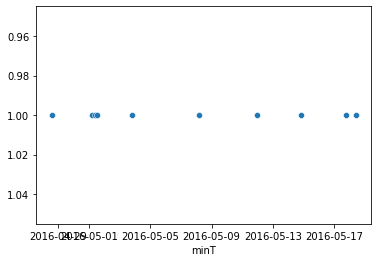

In [23]:
# time series plots of moriarty
sns.scatterplot(data=MoriartySessions, x='minT', y=1)
plt.gca().invert_yaxis()
plt.show()

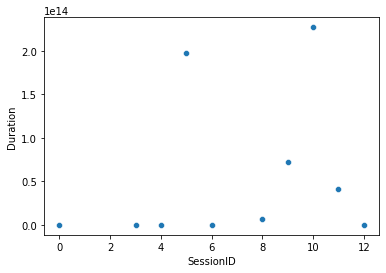

In [24]:
# duration of moriarty
sns.scatterplot(data=MoriartySessions, x='SessionID', y='Duration')
plt.gca().invert_yaxis()
plt.show()

## Feature engineering of Moriarty

In [25]:
binary = {'benign': 0, 'malicious': 1}
Moriarty = Moriarty.replace({'ActionType':binary})
Moriarty = Moriarty.replace({'SessionType':binary})
Moriarty

,UserId,UUID,Details,Action,ActionType,SessionType,Version,SessionID
0,97bb95f55a,2016-04-28 13:56:55.453,Added shortcut to the home screen(app);skype,Add Shortcut,1,1,5.0,0
1,97bb95f55a,2016-05-01 05:35:20.285,Login screen launched(login app);Skype,Shortcut Tapped,1,1,5.0,3
2,97bb95f55a,2016-05-01 05:35:20.288,App Entered onCreate(),App Mode Change,1,1,5.0,3
3,97bb95f55a,2016-05-01 05:35:20.378,App entered onResume(),App Mode Change,1,1,5.0,3
4,97bb95f55a,2016-05-01 05:35:39.256,Begin: Sending Password to server,Sending Data,1,1,5.0,3
5,97bb95f55a,2016-05-01 10:20:35.506,Login screen launched(login app);Facebook,Shortcut Tapped,1,1,5.0,4
6,97bb95f55a,2016-05-01 10:20:35.560,App Entered onCreate(),App Mode Change,1,1,5.0,4
7,97bb95f55a,2016-05-01 10:20:35.563,App entered onResume(),App Mode Change,1,1,5.0,4
8,97bb95f55a,2016-05-01 10:20:49.661,Begin: Sending Password to server,Sending Data,1,1,5.0,4
9,97bb95f55a,2016-05-01 12:25:10.549,App Entered onCreate(),App Mode Change,0,1,5.0,5


### Sensors

In [26]:
def magVector(df,col1,col2,col3):
    return ((df[col1].pow(2) + df[col2].pow(2) + df[col3].pow(2)).pow(1/2))
          
T2['magAccel'] = magVector(T2,'AccelerometerStat_x_MIDDLE_SAMPLE',
                           'AccelerometerStat_y_MIDDLE_SAMPLE',
                           'AccelerometerStat_z_MIDDLE_SAMPLE')
T2['magMag'] = magVector(T2,'MagneticField_x_MIDDLE_SAMPLE',
                           'MagneticField_y_MIDDLE_SAMPLE',
                           'MagneticField_z_MIDDLE_SAMPLE')
    
T2.head(3)

,UserID,UUID,Version,TimeStemp,AccelerometerStat_x_DC_FFT,AccelerometerStat_x_FIRST_IDX_FFT,AccelerometerStat_x_FIRST_VAL_FFT,AccelerometerStat_x_FOURTH_IDX_FFT,AccelerometerStat_x_FOURTH_VAL_FFT,AccelerometerStat_x_MEAN,...,AccelerometerStat_z_MIDDLE_SAMPLE,GyroscopeStat_x_MIDDLE_SAMPLE,GyroscopeStat_y_MIDDLE_SAMPLE,GyroscopeStat_z_MIDDLE_SAMPLE,MagneticField_x_MIDDLE_SAMPLE,MagneticField_y_MIDDLE_SAMPLE,MagneticField_z_MIDDLE_SAMPLE,pressure_MIDDLE_SAMPLE,magAccel,magMag
0,97bb95f55a,2016-04-27 21:32:55.659,2.2,2016-04-28 00:32:55.659,112.709439,256.0,0.070102,254.0,0.079229,-0.557968,...,8.746617,-0.010386,-0.007457,-0.007191,-21.90,-9.06,-36.78,991.6177,8.860996,43.754565
1,97bb95f55a,2016-04-27 21:33:15.462,2.2,2016-04-28 00:33:15.462,14.500483,256.0,0.010774,232.0,0.168699,-0.074745,...,8.868722,-0.011185,-0.008522,-0.007723,-22.74,-7.92,-37.86,991.6001,8.886932,44.868849
2,97bb95f55a,2016-04-27 21:33:35.793,2.2,2016-04-28 00:33:35.793,52.429426,256.0,0.021820,254.0,0.042375,-0.268869,...,8.807071,-0.009854,-0.007723,-0.008256,-22.32,-9.54,-36.84,991.6167,8.872734,44.117792


In [27]:
#### time series plots

## Extract Moriarty across datasets

In [28]:
x = Moriarty['UUID'][50]
print(x)
y = x + datetime.timedelta(seconds=3600)
AppPackages[((AppPackages['UUID'] > x) & (AppPackages['UUID'] < y))]

2016-05-08 05:23:02.006000


,UserId,UUID,Action,AppPackage,AppUID,App_Name,InstallSrc,InstallTime,PackageHASH,Permissions,...,versionCode,sherlock_version,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20


In [29]:
print(ScreenOn.shape)
ScreenOn.drop(ScreenOn[(ScreenOn['UUID'] > x) & (ScreenOn['UUID'] < (x + datetime.timedelta(seconds=0.0)))].index)

(1929, 4)


,UserID,UUID,ScreenOn,Timestamp
0,97bb95f55a,2016-04-27 23:21:44.991,1,2016-04-28 02:21:44.991
1,97bb95f55a,2016-04-27 23:22:50.983,0,2016-04-28 02:22:50.982
2,97bb95f55a,2016-04-27 23:25:35.929,1,2016-04-28 02:25:35.929
3,97bb95f55a,2016-04-27 23:25:47.083,0,2016-04-28 02:25:47.083
4,97bb95f55a,2016-04-27 23:25:58.976,1,2016-04-28 02:25:58.975
5,97bb95f55a,2016-04-27 23:26:08.904,0,2016-04-28 02:26:08.903
6,97bb95f55a,2016-04-28 03:48:25.242,1,2016-04-28 06:48:25.241
7,97bb95f55a,2016-04-28 03:48:44.583,0,2016-04-28 06:48:44.582
8,97bb95f55a,2016-04-28 04:30:03.324,1,2016-04-28 07:30:03.324
9,97bb95f55a,2016-04-28 04:31:09.901,0,2016-04-28 07:31:09.900


In [30]:
ScreenOn[((ScreenOn['UUID'] > x) & (ScreenOn['UUID'] < y))]

,UserID,UUID,ScreenOn,Timestamp
605,97bb95f55a,2016-05-08 05:30:03.335,1,2016-05-08 08:30:03.335
606,97bb95f55a,2016-05-08 05:30:15.544,0,2016-05-08 08:30:15.543
607,97bb95f55a,2016-05-08 05:49:06.871,1,2016-05-08 08:49:06.870
608,97bb95f55a,2016-05-08 05:54:59.023,0,2016-05-08 08:54:59.017
609,97bb95f55a,2016-05-08 05:58:04.198,1,2016-05-08 08:58:04.198
610,97bb95f55a,2016-05-08 05:58:13.794,0,2016-05-08 08:58:13.794
611,97bb95f55a,2016-05-08 05:58:15.442,1,2016-05-08 08:58:15.442
612,97bb95f55a,2016-05-08 05:58:40.489,0,2016-05-08 08:58:40.487
613,97bb95f55a,2016-05-08 05:58:41.667,1,2016-05-08 08:58:41.667
614,97bb95f55a,2016-05-08 05:58:42.002,0,2016-05-08 08:58:42.001


In [61]:
Moriarty = Moriarty.set_index('UUID')
ScreenOn = ScreenOn.set_index('UUID')
NEWDF=ScreenOn.append(Moriarty, sort=True)
NEWDF.sort_index()

,Action,ActionType,Details,ScreenOn,SessionID,SessionType,Timestamp,Version
UUID,,,,,,,,
2016-04-27 23:21:44.991,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:21:44.991,NaN
2016-04-27 23:22:50.983,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:22:50.982,NaN
2016-04-27 23:25:35.929,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:25:35.929,NaN
2016-04-27 23:25:47.083,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:25:47.083,NaN
2016-04-27 23:25:58.976,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 02:25:58.975,NaN
2016-04-27 23:26:08.904,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 02:26:08.903,NaN
2016-04-28 03:48:25.242,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 06:48:25.241,NaN
2016-04-28 03:48:44.583,NaN,NaN,NaN,0.0,NaN,NaN,2016-04-28 06:48:44.582,NaN
2016-04-28 04:30:03.324,NaN,NaN,NaN,1.0,NaN,NaN,2016-04-28 07:30:03.324,NaN


In [32]:
unit type action type
malicious vs benigin

SyntaxError: invalid syntax (<ipython-input-32-b6335c1ac500>, line 1)

In [ ]:
###### predict is screen on from magnitude

In [ ]:
#### predict screen on moriarty...

In [ ]:
sns.distplot(T2['AccelerometerStat_x_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_x_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

In [ ]:
sns.distplot(T2['AccelerometerStat_y_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_y_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

In [ ]:
sns.distplot(T2['AccelerometerStat_z_MIDDLE_SAMPLE'])
plt.title('Histogram: AccelerometerStat_z_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

In [ ]:
sns.distplot(T2['pressure_MIDDLE_SAMPLE'])
plt.title('Histogram: pressure_MIDDLE_SAMPLE')
plt.xlabel('_something_')
f = plt.gcf()
f.set_size_inches(6,3)
plt.show()

### Goofy stuff

In [ ]:
t2_accelero = T2[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE',
                  'pressure_MIDDLE_SAMPLE']]

t2_accelero.isnull().values.any()
t2_accelero = t2_accelero.dropna()
t2_accelero.isnull().values.any()

t2_accelero_X = t2_accelero[['AccelerometerStat_x_MIDDLE_SAMPLE', 
                  'AccelerometerStat_y_MIDDLE_SAMPLE', 
                  'AccelerometerStat_z_MIDDLE_SAMPLE']]
t2_accelero_y = t2_accelero[['pressure_MIDDLE_SAMPLE']]

X_train, X_test, y_train, y_test = train_test_split(t2_accelero_X, t2_accelero_y, random_state=42)

### Pipeline for pipeline assignment

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

Pretty poor, eh?  Well, what would you expect from a random grab...

### Pickle the model

In [ ]:
with open('model.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(pipe, f, pickle.HIGHEST_PROTOCOL)

### Create faux-data

In [ ]:
print(X_test[0:2].values.tolist())

### Tests

In [ ]:
from newdata import newdata
newdata

In [ ]:
with open('model.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    pipePKL = pickle.load(f)

In [ ]:
predictions = pipePKL.predict(newdata)
print(predictions)